# Note: I changed some of the code provided. I removed SPY from data set early on to stop it from haunting me everywhere. I thus also removed all 'assert' lines. Lots of useless lines in this document ngl. Was a little bothered so I removed some of them. I also did some decoration by adding my own helper lines, etc. If I were to write this all the way from beginning, I'd put a lot more of some trash repetitive code in funcs.

## Eigen-portfolio construction using Principal Component Analysis (PCA)

### PCA via sklearn.decomposition using S&P 500 Index stock data

Welcome to your first assignment in Unsupervised Machine Learning in Finance.

In this assignment we look in-depth at model-free factor analysis using PCA. By model-free we mean that we do not rely on any factors such as value or momentum to decompose portfolio returns, but instead using Principal Component Analysis (PCA) to deduce structure of portfolio returns.

We work with S&P 500 index stock data. 

Please read the attached article by Avellaneda and Lee which can also be found at:
http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf


## General Instructions ##

You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [2]:
import os
import os.path
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams

import sys
sys.path.append("..")
# import grading


# standard magic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# disable warnings
import warnings
warnings.filterwarnings('ignore')

## Part 0 : Read Data 
### Instruction:
### Please fill the '####' to read the data of spx_holdings_and_spx_closeprice.csv

In [3]:
# load dataset
all_prices = pd.read_csv('C:/Users/Allen Tao/Desktop/FRE 7773/Assignments/A5/A5 Data/data.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
asset_prices = all_prices.iloc[:, :-1] # remove SPY once and for all
n_stocks_show = 15
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3493, 418)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AGN
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625,37.9375,20.5938,39.688
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000,38.1875,21.0000,40.250
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000,40.0625,21.7188,40.313
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875,40.3750,22.1563,41.375
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250,39.6563,22.1875,42.813


#### Part 1 (Asset Returns Calculation)
**Instructions:**

Calculate percent returns, also known as simple returns using asse_prices. assign the result to variable asset_returns. Keep only not-nan values in the resulting pandas.DataFrame

Calculate de-meaned returns and scale them by standard deviation $\sigma$. Assign result to normed_returns variable

We now compute stock returns and normalize stock returns data by subtracting the mean and dividing by standard diviation. This normalization is required by PCA.

In [4]:
asset_returns = pd.DataFrame(data=np.zeros(shape=(len(asset_prices.index), asset_prices.shape[1])), 
                             columns=asset_prices.columns.values,
                             index=asset_prices.index)

### START CODE HERE ### (≈ 4 lines of code)
all_prices_returns = all_prices.pct_change(1)
all_prices_returns.dropna(axis=0, inplace=True)
asset_returns = all_prices_returns.iloc[:, :-1]


# normed_returns is pandas.DataFrame that should contain normalized returns
# normed_returns
normed_returns = (asset_returns - asset_returns.mean()) / asset_returns.std(ddof=1)

### END CODE HERE ###

normed_returns.iloc[-5:, -10:].head()


,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1
2013-12-16,-0.065624,0.852722,0.965219,-1.168885,0.884751,0.095865,0.656639,0.180014,-0.238498,0.465047
2013-12-17,-0.496711,0.275173,0.517307,-0.086106,-0.306213,0.589689,-0.118610,-0.549523,0.025268,-0.260013
2013-12-18,1.012144,0.864485,0.509435,0.600714,1.210605,-0.190024,0.925461,0.756998,0.058428,0.952458
2013-12-19,-0.115034,0.210069,0.399574,-0.100159,-0.757419,-0.208023,0.304913,-0.772205,1.544228,-0.167775
2013-12-20,0.361476,0.827306,0.748420,0.372443,1.048113,0.264046,0.436874,0.320641,-0.740854,0.373717


In [5]:
train_end = datetime.datetime(2012, 3, 26) 

df_train = None
df_test = None
df_raw_train = None
df_raw_test = None

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3055, 418)
Test dataset: (437, 418)


In [6]:
spy_raw_test = all_prices_returns.SPX[df_raw_test.index]
spy_raw_test

2012-03-27   -0.002817
2012-03-28   -0.004942
2012-03-29   -0.001608
2012-03-30    0.003698
2012-04-02    0.007505
                ...   
2013-12-16    0.006320
2013-12-17   -0.003101
2013-12-18    0.016648
2013-12-19   -0.000580
2013-12-20    0.004819
Name: SPX, Length: 437, dtype: float64

#### Part 2 (PCA fitting)
**Instructions:**
- Calculate covariance matrix using training data set, i.e. **df_train** for all assets.  Assign results to **cov_matrix**.
- Calculate covariance matrix using training data set, i.e. **df_raw_train** for all assets.  Assign results to **cov_matrix_raw**.
- Use scikit-learn PCA to fit PCA model to **cov_matrix**. Assign fitted model to **pca**

In [7]:
stock_tickers = normed_returns.columns.values
n_tickers = len(stock_tickers)
n_tickers # I kicked SPY out earlier on 

418

In [8]:
cov_matrix = df_train.cov()
cov_raw_matrix = df_raw_train.cov()
cov_matrix

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1
A,1.104466,0.439162,0.398369,0.185769,0.145685,0.459210,0.589315,0.255257,0.371152,0.441491,...,0.358685,0.305122,0.170880,0.202256,0.331676,0.568075,0.331807,0.154200,0.374973,0.416130
AA,0.439162,1.094241,0.322609,0.297756,0.296690,0.384242,0.373410,0.480384,0.461335,0.402252,...,0.436178,0.333620,0.303222,0.312575,0.447970,0.457299,0.468958,0.303627,0.727330,0.540264
AAPL,0.398369,0.322609,1.081901,0.177206,0.150544,0.450774,0.462401,0.228062,0.321280,0.395329,...,0.337683,0.178453,0.180334,0.194835,0.277540,0.488443,0.255837,0.116257,0.334717,0.375402
ABC,0.185769,0.297756,0.177206,1.105170,0.365925,0.259723,0.223895,0.276246,0.330277,0.231413,...,0.241031,0.318381,0.231832,0.243912,0.344060,0.209836,0.228121,0.281468,0.265613,0.295924
ABT,0.145685,0.296690,0.150544,0.365925,1.069415,0.195646,0.167520,0.277324,0.354253,0.194376,...,0.267619,0.358256,0.217352,0.294879,0.362874,0.143725,0.229957,0.235307,0.235913,0.266497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TER,0.568075,0.457299,0.488443,0.209836,0.143725,0.529515,0.731165,0.266953,0.411421,0.475756,...,0.376529,0.253931,0.187078,0.203418,0.337117,1.103402,0.375394,0.204456,0.409339,0.452963
TGNA,0.331807,0.468958,0.255837,0.228121,0.229957,0.306467,0.289853,0.332320,0.394873,0.354415,...,0.388376,0.247927,0.253216,0.255313,0.416604,0.375394,1.030079,0.257173,0.440915,0.490267
THC,0.154200,0.303627,0.116257,0.281468,0.235307,0.157708,0.144621,0.208239,0.192880,0.206354,...,0.215610,0.209903,0.205851,0.213507,0.230058,0.204456,0.257173,1.074773,0.298852,0.280750
X,0.374973,0.727330,0.334717,0.265613,0.235913,0.361779,0.351938,0.451547,0.401276,0.397544,...,0.382905,0.318118,0.280665,0.304756,0.425424,0.409339,0.440915,0.298852,1.055259,0.514880


In [9]:
from sklearn.decomposition import PCA

if df_train is not None and df_raw_train is not None:

    ### START CODE HERE ### (≈ 2-3 lines of code)
    # computing PCA on S&P 500 stocks
    pca = PCA()
    pca.fit(cov_matrix)
    # not normed covariance matrix
    
    ### END CODE HERE ###
    
    cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=stock_tickers)    
    # cumulative variance explained
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
    print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

PCA()

NameError: name 'cov_matrix_raw' is not defined

In [ ]:
if pca is not None:
    bar_width = 0.9;
    n_asset = int((1 / 10) * normed_returns.shape[1]);
    x_indx = np.arange(n_asset);
    fig, ax = plt.subplots();
    fig.set_size_inches(12, 4);
    # Eigenvalues are measured as percentage of explained variance.
    rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue');
    ax.set_xticks(x_indx + bar_width / 2);
    ax.set_xticklabels(list(range(n_asset)), rotation=45);
    ax.set_title('Percent variance explained');
    ax.legend((rects[0],), ('Percent variance explained by principal components',));

In [ ]:
if pca is not None:
    projected = pca.fit_transform(cov_matrix)

In [ ]:
projected.shape

#### Part 3 (Eigen-portfolios construction)

**Instructions:**

We now look a the first two eigen portfolios. We use definition of eigen portfolios as provided by Avellaneda 
http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf

Following Avellaneda we define eigen portfolio weights as:
$$Q_i^{(j)} = \frac{v_i^{(j)}}{\sigma_i}$$

where $j$ is the index of eigen portfolio and $v_i$ is the i-th element of j-th eigen vector.

In the code the pca.components_ are the Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.

**Hint:** do not forget to normalize portfolio wieghts such they sum up to 1.

Assign **pc_w** to be weights of the first eigen portfolio.

In [10]:
# the first two eigen-portfolio weights
# first component
# get the Principal components
pc_w = np.zeros(len(stock_tickers))
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)


Sum of weights of first eigen-portfolio: 100.00


<AxesSubplot:title={'center':'First eigen-portfolio weights'}>

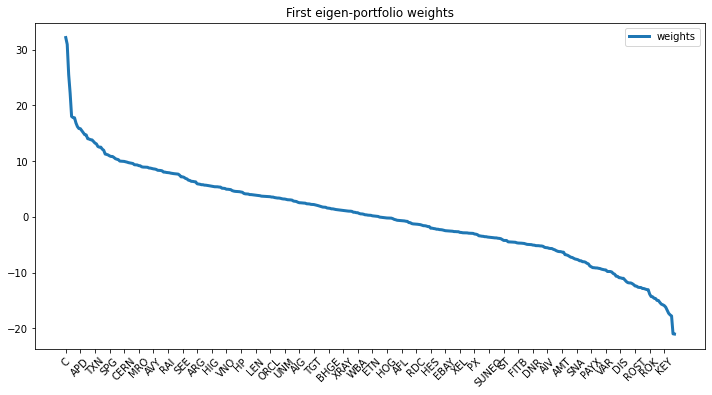

In [33]:
if pca is not None:
    pcs = pca.components_[:,0]

    ### START CODE HERE ### (≈ 1-2 lines of code)
    # normalized to 1 
    pc_w = pcs / np.sum(pcs)    
    ### END CODE HERE ###
    
    eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
    eigen_prtf1.plot(title='First eigen-portfolio weights', 
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

We sort the first two eigen portfolio weights and plot the results.

Sum of weights of second eigen-portfolio: 100.00


<AxesSubplot:title={'center':'Second eigen-portfolio weights'}>

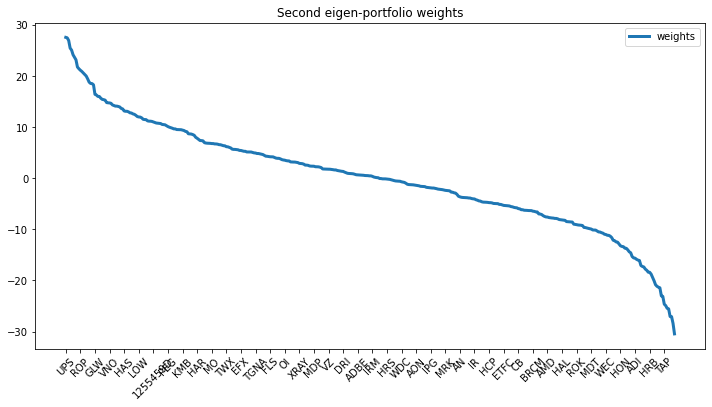

In [13]:
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)

if pca is not None:
    pcs = pca.components_[:,1]

    ### START CODE HERE ### (≈ 1-2 lines of code)
    # normalized to 1 
    pc_w = pcs / np.sum(pcs)
    
    ### END CODE HERE ###

    eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
    eigen_prtf2.plot(title='Second eigen-portfolio weights',
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

Sum of weights of second eigen-portfolio: 100.00


<AxesSubplot:title={'center':'Second eigen-portfolio weights'}>

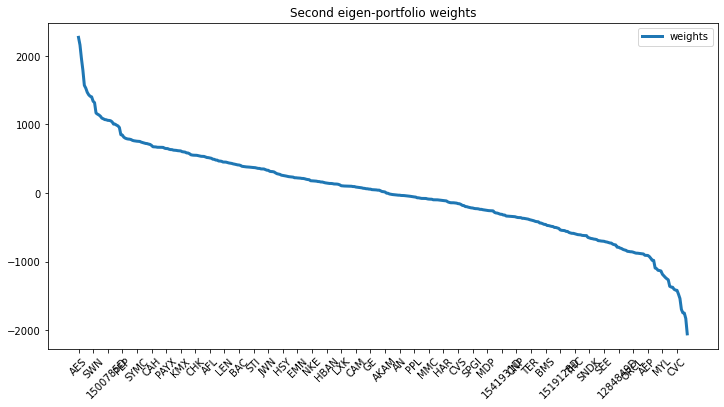

In [35]:
eigen_prtf20 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)

if pca is not None:
    pcs = pca.components_[:,19]

    ### START CODE HERE ### (≈ 1-2 lines of code)
    # normalized to 1 
    pc_w = pcs / np.sum(pcs)
    
    ### END CODE HERE ###

    eigen_prtf20 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf20.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
    eigen_prtf20.plot(title='Second eigen-portfolio weights',
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

#### Part 4 (Compute performance of several eigen portfolios)

**Instructions:**
- Implement sharpe_ratio() function. The function takes ts_returns argument of type pd.Series and returns a tuple of annualized return, annualized vol, and annualized sharpe ratio, where sharpe ratio is defined as annualized return divided by annualized volatility 
- find portfolio (an index into sharpe_metric) that has the highest sharpe ratio

In [14]:
eigen_prtf1

,weights
C,32.156276
IR,30.933928
IRM,25.507764
AMZN,22.167479
EMR,18.008921
...,...
FOXA,-17.313521
FLIR,-17.600672
NVDA,-17.795781
DO,-21.001381


In [48]:
# weighted return everyday
eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)


In [49]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """

    ### START CODE HERE ### (≈ 4-5 lines of code)
    cum_ret = (ts_returns + 1).cumprod()
    annualized_return = (cum_ret[-1] / cum_ret[0]) ** (len(cum_ret) / periods_per_year) - 1
    annualized_vol = ts_returns.std(ddof=1) * periods_per_year ** 0.5
    annualized_sharpe = annualized_return / annualized_vol
    ### END CODE HERE ###
    
    return annualized_return, annualized_vol, annualized_sharpe

We compute the annualized return, volatility, and Sharpe ratio of the first two eigen portfolios.

First eigen-portfolio:
Return = 180.44%
Volatility = 31.50%
Sharpe = 5.73


<AxesSubplot:title={'center':'Returns of the market-cap weighted index vs. First eigen-portfolio'}>

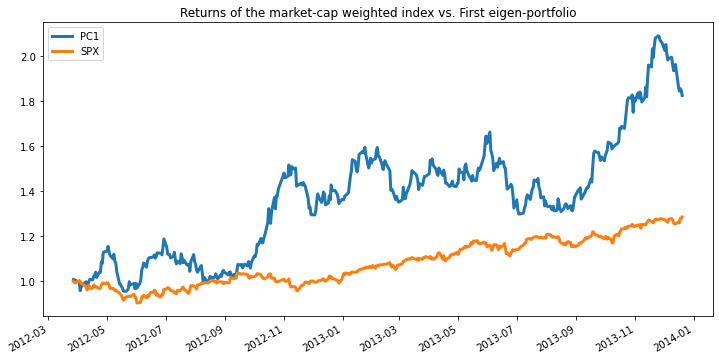

In [50]:
if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252 # this line is useless

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, 'SPX': spy_raw_test}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

Second eigen-portfolio:
Return = 53.55%
Volatility = 42.84%
Sharpe = 1.25


<AxesSubplot:title={'center':'Returns of the market-cap weighted index vs. First eigen-portfolio'}>

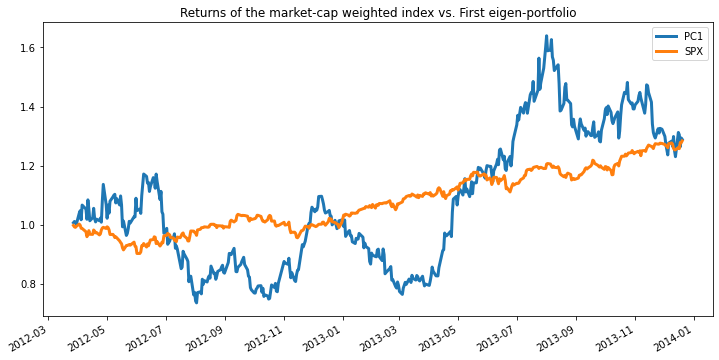

In [51]:
if df_raw_test is not None:
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    df_plot = pd.DataFrame({'PC1': eigen_prtf2_returns, 'SPX': spy_raw_test}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

We repeat the exercise of computing Sharpe ratio for the first N portfolios and select portfolio with the highest postive Sharpe ratio.

In [52]:
n_portfolios = 120
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)

Eigen portfolio #97 with the highest Sharpe. Return 1318.09%, vol = 60.98%, Sharpe = 21.62


Text(0.5, 1.0, 'Sharpe ratio of eigen-portfolios')

Text(0, 0.5, 'Sharpe ratio')

Text(0.5, 0, 'Portfolios')

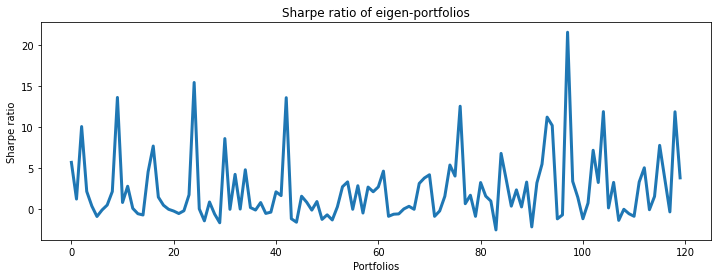

In [55]:
if pca is not None:
    for ix in range(n_portfolios):
        ### START CODE HERE ### (≈ 4-5 lines of code)
        # weights
        pcs = pca.components_[:,ix]
        pc_w = pcs / np.sum(pcs)
        
        # form portfoliio
        portfolio = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
        
        # weighted returns
        wret = np.dot(df_raw_test.loc[:, portfolio.index], portfolio / 100)
        
        
        #find sharpe
        ret, vol, sharpe = sharpe_ratio(wret)
        
        # fill in 
        annualized_ret[ix] = ret
        annualized_vol[ix] = vol
        sharpe_metric[ix] = sharpe 
        annualized_ret[np.isnan(annualized_ret)] = 0
        annualized_vol[np.isnan(annualized_vol)] = 0
        sharpe_metric[np.isnan(sharpe_metric)] = 0
        ### END CODE HERE ###
    
        
    # find portfolio with the highest Sharpe ratio
    ### START CODE HERE ### (≈ 2-3 lines of code)
    idx_highest_sharpe = np.argmax(sharpe_metric)
    
    ### END CODE HERE ###
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (idx_highest_sharpe,
           annualized_ret[idx_highest_sharpe]*100, 
           annualized_vol[idx_highest_sharpe]*100, 
           sharpe_metric[idx_highest_sharpe]))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

In [56]:
results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
results.head(10)

,Return,Vol,Sharpe
97,13.180881,0.609754,21.616713
24,6.572691,0.424530,15.482287
9,4.461623,0.326692,13.656968
42,3.107348,0.228033,13.626749
76,7.591876,0.603325,12.583397
104,2.547683,0.213640,11.925118
118,5.803919,0.487549,11.904280
93,3.051041,0.271151,11.252176
94,2.311899,0.225976,10.230739
2,2.083700,0.206247,10.102933


In [57]:
print('Done!')

Done!
